# Testing Augmentations

In [2]:
from bids_dataset import BidsDataModule, BidsDataset
import matplotlib.pyplot as plt
import numpy as np
import math
import monai
import os
import sys
from pathlib import Path
from monai.transforms import (
    Activations,
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    RotateD, 
    RandRotateD,
    ScaleIntensityd
)
from monai.visualize import plot_2d_or_3d_image
import TPTBox
from TPTBox import NII

current_dir = os.getcwd()

file = Path(current_dir).resolve()
sys.path.append(str(file.parents[1]))
sys.path.append(str(file.parents[2]))

from utils import brats_tools

In [3]:
brats_path = "/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train"
prefix = "BraTS-GLI-"
brats_data= BidsDataset(brats_path, binary = False, prefix = prefix)
test_idx = 2
test_dict = brats_data[test_idx]
img, mask = test_dict['img'], test_dict['seg']
print (img.shape, mask.shape)
brats_keys = ['img', 'seg']

INFO:root:Loaded MRI image and segmentation mask for subject 00012-000.


torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


## Testing RandRotateD

### Testing on pure Data taken from the Dataset

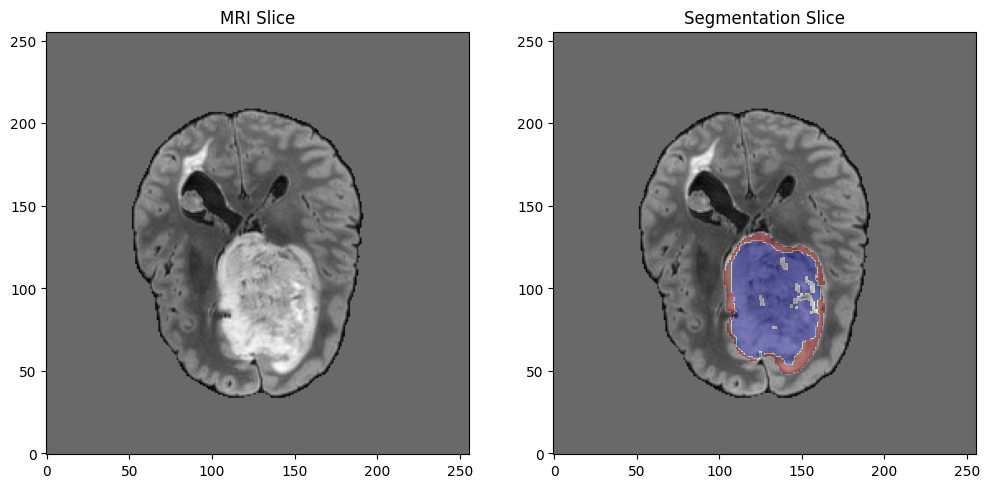

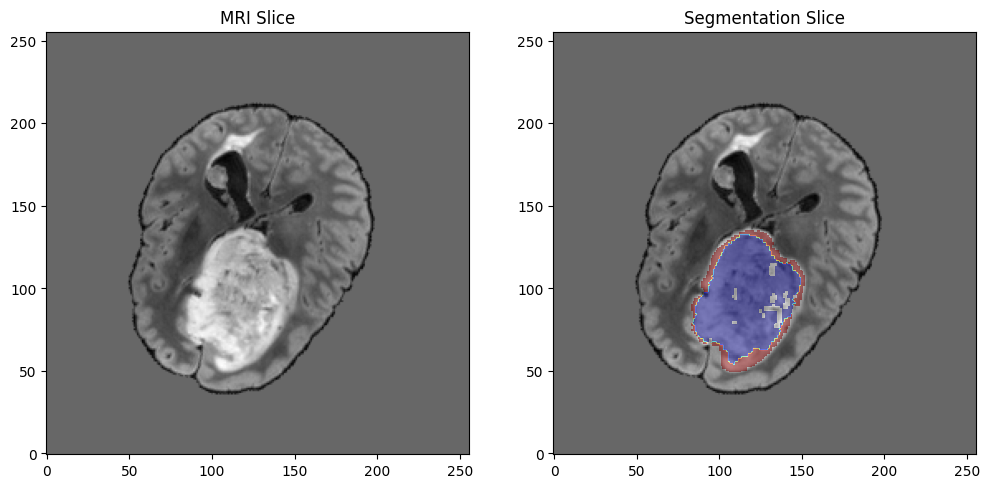

In [4]:
# Random rotation by 30 degrees works
rotate = RandRotateD(keys=brats_keys, range_x=[- math.radians(30), math.radians(30)], prob=1, mode =["bilinear", "nearest"])
dict = {"img": img, "seg": mask}
transformed = rotate(dict)
transformed_img, transformed_mask = transformed["img"], transformed["seg"]

img_np = img.squeeze().numpy()
mask_np = mask.squeeze().numpy()
transformed_img_np = transformed_img.squeeze().numpy()
transformed_mask_np = transformed_mask.squeeze().numpy()

#Plotting
brats_tools.plot_slices(img_np, mask_np, 'Original')
brats_tools.plot_slices(transformed_img_np, transformed_mask_np, 'Transformed')

### Testing application of transform through Dataset/inside Dataset

In [5]:
train_transform = Compose(
    [
        #EnsureChannelFirstd(brats_keys),
        RandRotateD(keys=brats_keys, range_x=[- math.radians(30), math.radians(30)], prob=1, mode =["bilinear", "nearest"]),
    ]
)

#train_transform = RandRotateD(keys=brats_keys, range_x=[- math.radians(30), math.radians(30)], prob=1, mode =["bilinear", "nearest"])

In [6]:
brats_path = "/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train"
prefix = "BraTS-GLI-"
train_ds = BidsDataset(brats_path, binary = False, prefix = prefix, transform = train_transform)

INFO:root:Loaded MRI image and segmentation mask for subject 00012-000.


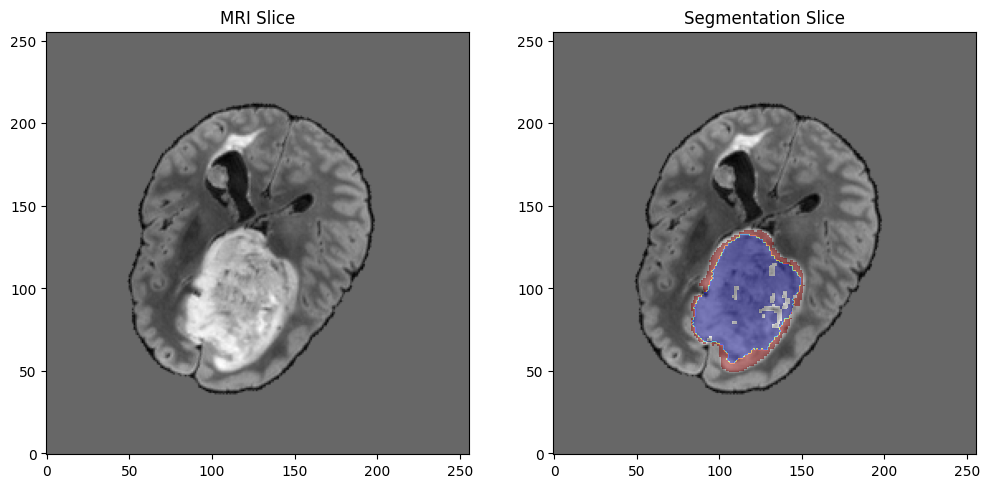

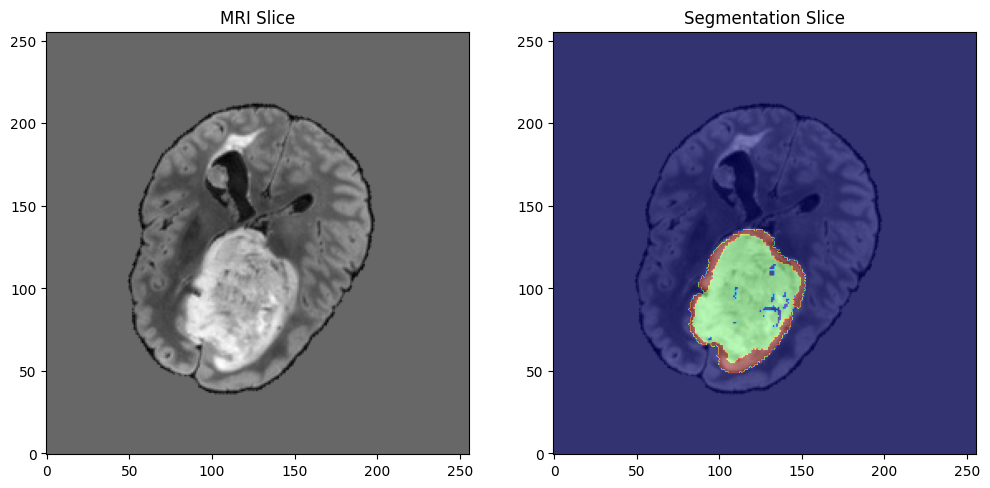

In [7]:
check_idx = 2
check_dict = train_ds[check_idx]
img, mask = check_dict['img'].squeeze().numpy(), check_dict['seg'].squeeze().numpy()
brats_tools.plot_slices(img, mask,'Check if transform inside BidsDataset works' ,omit_background=True)
brats_tools.plot_slices(img, mask,'Check if transform inside BidsDataset works' ,omit_background=False)

#### Checking how filling the holes in the seg mask would work

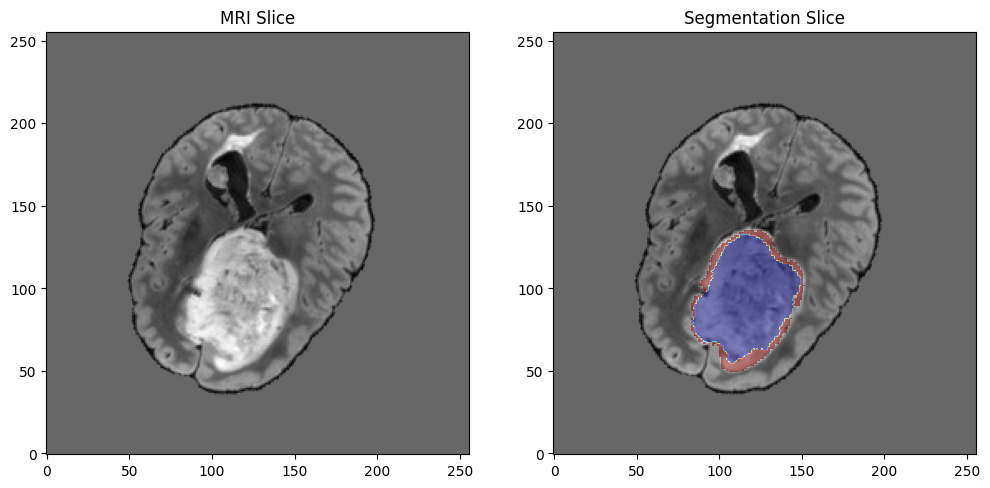

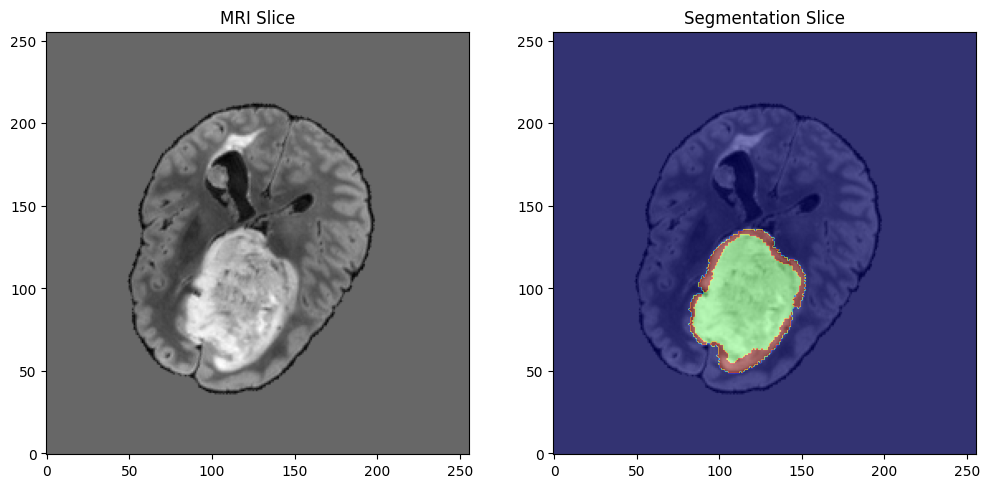

In [8]:
import TPTBox

modified_mask = TPTBox.np_utils.np_fill_holes(mask)

brats_tools.plot_slices(img, modified_mask,'Check if transform inside BidsDataset works' ,omit_background=True)
brats_tools.plot_slices(img, modified_mask,'Check if transform inside BidsDataset works' ,omit_background=False)

#### Check original img and seg for comparison if holes also exist there

In [9]:
def get_center_slice(img):
    #img is a Nifti1Image object
    data = img.get_fdata()
    center = data.shape[2] // 2     #Assuming the third dimension is the axial dimension
    return data[:, :, center]

Straight from File using TPTBox.NII.load()
nii_img.shape: (240, 240, 155), nii_mask.shape: (240, 240, 155)
nii_img.dtype: int16, nii_mask.dtype: float32
Using .get_array() method from NII object
img.shape: (240, 240, 155), mask.shape: (240, 240, 155)
img.dtype: int16, mask.dtype: uint16
img_center: 77
After slicing
nii_img_slice.dtype: int16 check_mask.dtype: uint16
check_img.dtype: int16, check_mask.dtype: uint16


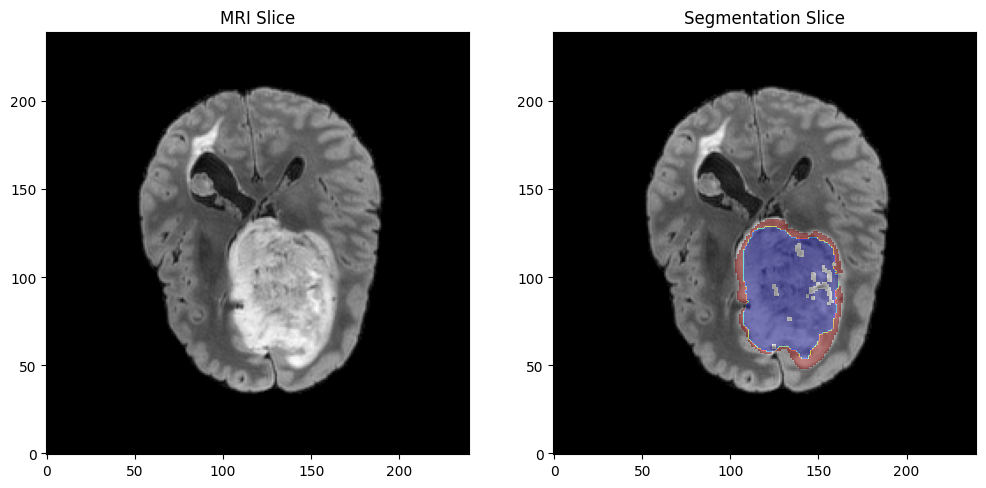

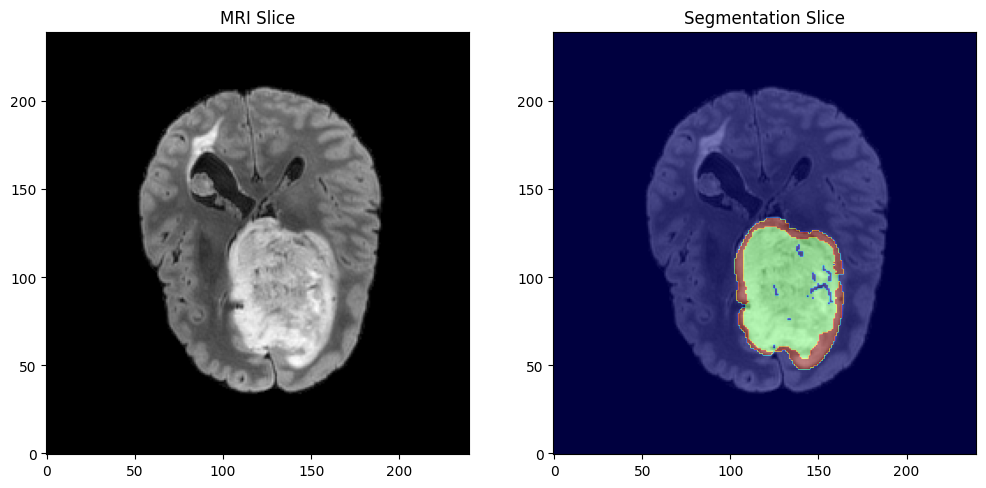

In [31]:
img_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train/BraTS-GLI-00012-000/BraTS-GLI-00012-000-t2f.nii.gz'
seg_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train/BraTS-GLI-00012-000/BraTS-GLI-00012-000-seg.nii.gz'

nii_img, nii_mask = NII.load(img_path, False), NII.load(seg_path, True)

print(f"Straight from File using TPTBox.NII.load()")
print(f"nii_img.shape: {nii_img.shape}, nii_mask.shape: {nii_mask.shape}")
print(f"nii_img.dtype: {nii_img.dtype}, nii_mask.dtype: {nii_mask.dtype}")

img, mask = nii_img.get_array(), nii_mask.get_array()

print(f"Using .get_array() method from NII object")
print(f"img.shape: {img.shape}, mask.shape: {mask.shape}")
print(f"img.dtype: {img.dtype}, mask.dtype: {mask.dtype}")

img_center = img.shape[2] // 2     #Assuming the third dimension is the axial dimension
print(f"img_center: {img_center}")

img_slice, mask_slice = img[:, :, img_center], mask[:, :, img_center]

print(f"After slicing")
print(f"nii_img_slice.dtype: {img_slice.dtype} check_mask.dtype: {mask_slice.dtype}")
print(f"check_img.dtype: {img.dtype}, check_mask.dtype: {mask.dtype}")

brats_tools.plot_slices(img_slice, mask_slice, 'Check original image', omit_background=True)
brats_tools.plot_slices(img_slice, mask_slice, 'Check original image', omit_background=False)

### Testing if transform works after DataModule_

In [11]:
# Added train_transforms inside DataModule which is then given to Dataset
brats_root_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge'
bids_dm = BidsDataModule(brats_root_path, binary = False, train_transform = train_transform, batch_size=2)

INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00048-000.
INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00009-000.
INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00021-000.
INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00071-000.
INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00008-000.
INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00046-000.
INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00062-000.
INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00058-001.
INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00072-000.
INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00022-000.
INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00058-000.
INFO:root:Loaded MRI image and segmentation mask for subject BraTS-GLI-00088-001.
INFO:root:Loaded


-------------------------------

Batch size: 2
imgs.shape: torch.Size([2, 1, 256, 256]), masks: torch.Size([2, 1, 256, 256])


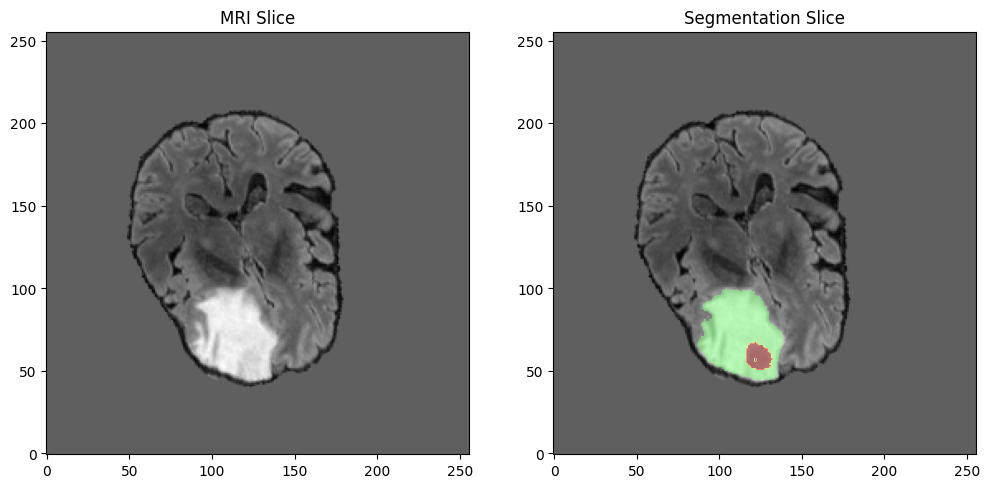

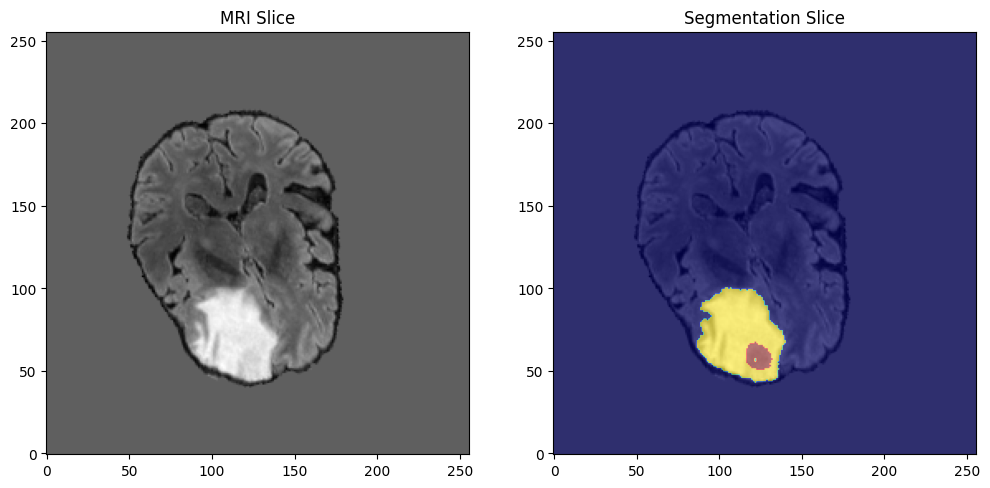

In [59]:
bids_dm.setup()
train_dl = bids_dm.train_dataloader()
sample_batch = next(iter(train_dl))
print(f"\n-------------------------------\n")
print(f"Batch size: {len(sample_batch)}")
imgs, masks = sample_batch['img'], sample_batch['seg']
print(f"imgs.shape: {imgs.shape}, masks: {masks.shape}")

test_idx = 0

sample_img = imgs[test_idx].squeeze().numpy()
sample_mask = masks[test_idx].squeeze().numpy()
brats_tools.plot_slices(sample_img, sample_mask,'Check if transform inside BidsDatamodule works' ,omit_background=True)
brats_tools.plot_slices(sample_img, sample_mask,'Check if transform inside BidsDatamodule works' ,omit_background=False)
